# Response time minimization - Nordland police district

### Version 4.0

- Goal: Minimize the response time of police vehicles to events within police district.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.

#### Nordland police district
Nordland police district covers Gratangen municipality in Troms, as well as all municipalities in Nordland, with the exception of Bindal municipality (which is covered by Trøndelag police district). The police district's headquarters are in Bodø.


In [2]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-29T10:24:32.376989+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shapely.geometry import Point, MultiPolygon
from descartes import PolygonPatch
import geopandas as gpd
import osmnx as ox
import pandana as pdna
import utilityModule # custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

osmnx     : 1.9.1
pandana   : 0.7
geopandas : 0.14.3
pandas    : 2.2.1
numpy     : 1.26.4
matplotlib: 3.8.3



## 0. Load road network

We load a preprocessed graph (road network) from file. This has been prepared using the corresponding preprocessing script.  
The graph is a MultiDiGraph clipped after the boundaries of Oslo police district. Imported as WGS84 (EGSG:4326) and will be converted to UTM33N (EPSG:32633) before the analysis.  
Network node centrality has been computed and saved locally. Edges contain road speeds and travel times. Road speeds have been increased by 20-40% to simulate police vehicle speeds.

In [4]:
### Load road network from file
Nordland_filepath = "../data/Nordland/NordlandDriveImputed.graphml" # with travel time attribute
Nordland_graph = ox.load_graphml(Nordland_filepath) # originally in WGS84 (EPSG:4326)

In [5]:
Nordland_graph = ox.projection.project_graph(Nordland_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of Nordland_graph: {type(Nordland_graph)}")
print(f"CRS of Nordland_graph:  {Nordland_graph.graph['crs']}")

# # plot graph
# fig, ax = ox.plot_graph(Nordland_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of Nordland_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of Nordland_graph:  EPSG:32633


Convert MultiDiGraph to node and edge GeoDataFrames.

In [6]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(Nordland_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid lanes               name  \
u         v          key                                                   
201344755 8977449204 0    [59426322, 167195250]     2  Svenningdalsvegen   
          5752176302 0     [59426322, 59426323]     2  Svenningdalsvegen   

                               highway  maxspeed width  oneway       reversed  \
u         v          key                                                        
201344755 8977449204 0    unclassified        70     7   False  [False, True]   
          5752176302 0    unclassified  [70, 60]     7   False           True   

                           length  \
u         v          key            
201344755 8977449204 0   3128.367   
          5752176302 0    241.094   

                                                                   geometry  \
u         v          key                                                      
201344755 8977449204 0    LINESTRING (426116.773 7258568.424, 426116.802...   
          5752176302 0    LINESTRING (426116.773 7258568.424, 426116.772...   

                          speed_kph  travel_time bridge  ref tunnel junction  \
u         v          key                                                       
201344755 8977449204 0       70.000      160.900    NaN  NaN    NaN      NaN   
          5752176302 0       65.000       13.400    NaN  NaN    NaN      NaN   

                         access service  
u         v          key                 
201344755 8977449204 0      NaN     NaN  
          5752176302 0      NaN     NaN

Increase road speeds by 20-40% to simulate more realistic police vehicle speeds. Increased speed ($y$) is computed based on the original speed ($x$) using a 3rd degree polynomial function:  
$y = 0.0000232614692 * x^3 + 0.00692679011 * x^2 + 0.836197811 * x + 5.20808653$

- For 20 kph, increased speed is 24.52 kph (22.58% increase)
- For 70 kph, increased speed is 89.70 kph (28.15% increase)
- For 110 kph, increased speed is 150.04 kph (36.40% increase)

In [7]:
# increase speed of edges
edges_increased = utilityModule.increase_edge_speeds(edges)
edges_increased.head(2) # verify increased edge speeds and shorter travel times

osmid lanes               name  \
u         v          key                                                   
201344755 8977449204 0    [59426322, 167195250]     2  Svenningdalsvegen   
          5752176302 0     [59426322, 59426323]     2  Svenningdalsvegen   

                               highway  maxspeed width  oneway       reversed  \
u         v          key                                                        
201344755 8977449204 0    unclassified        70     7   False  [False, True]   
          5752176302 0    unclassified  [70, 60]     7   False           True   

                           length  \
u         v          key            
201344755 8977449204 0   3128.367   
          5752176302 0    241.094   

                                                                   geometry  \
u         v          key                                                      
201344755 8977449204 0    LINESTRING (426116.773 7258568.424, 426116.802...   
          5752176302 0    LINESTRING (426116.773 7258568.424, 426116.772...   

                          speed_kph  travel_time bridge  ref tunnel junction  \
u         v          key                                                       
201344755 8977449204 0       89.705      125.547    NaN  NaN    NaN      NaN   
          5752176302 0       82.438       10.528    NaN  NaN    NaN      NaN   

                         access service  
u         v          key                 
201344755 8977449204 0      NaN     NaN  
          5752176302 0      NaN     NaN

In [8]:
# recombining nodes and increased edges to MultiDiGraph format
Nordland_graph_increased = ox.graph_from_gdfs(nodes, edges_increased)

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based on population count.  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data in 250x250m grid cells from SSB.

In [9]:
# load preprocessed polygon data and convert to CRS UTM zone 33N (EPSG:32633)
Nordland_polygon_path = "../data/Nordland/NordlandCombinedPolygon.geojson"
Nordland_polygon_gdf = gpd.read_file(Nordland_polygon_path)
Nordland_polygon_gdf = Nordland_polygon_gdf.to_crs(Nordland_graph.graph['crs']) # convert to same CRS as the road network

In [10]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
population_path = "../data/Nordland/NordlandPopulation.geojson"
population_gdf = gpd.read_file(population_path)
population_gdf = population_gdf.to_crs(Nordland_graph.graph['crs']) # convert to same CRS as the road network

In [11]:
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


id  population  \
0  23615007235500           3   
1  23672507237500           1   

                                            geometry  
0  POLYGON ((361500.000 7235500.000, 361500.000 7...  
1  POLYGON ((367250.000 7237500.000, 367250.000 7...

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range.

In [12]:
# calculate the number of points to simulate in each grid cell - vectorized version
# population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1500, max_range=1550) # few events, fast testing
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1250, max_range=1300) # std pop multiplier
# standard population multiplier: 0.008347656250000002

# # print the number of cells with 0, 1, 2, ..., 9 events
# for i in range(0, 7):
#     print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 1279. Target range [1250, 1300], using population multiplier: 0.008347656250000002


id  population  \
9155  24735007463000         677   
9132  24727507462500         595   
9187  24747507463750         611   

                                               geometry  num_points  
9155  POLYGON ((473500.000 7463000.000, 473500.000 7...           6  
9132  POLYGON ((472750.000 7462500.000, 472750.000 7...           5  
9187  POLYGON ((474750.000 7463750.000, 474750.000 7...           5

In [13]:
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

geometry
0  POINT (368054.442 7245988.412)
1  POINT (369161.658 7252205.190)
2  POINT (369369.084 7252150.450)

In [14]:
# create polygons around high event density areas
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, 
                        density_threshold=7.5e-12, simplification_tolerance=5.0, plot_results=False)

Density: Min: 5.634e-66 | Median: 1.335e-12 | Mean: 8.635e-12 | Max: 1.355e-10


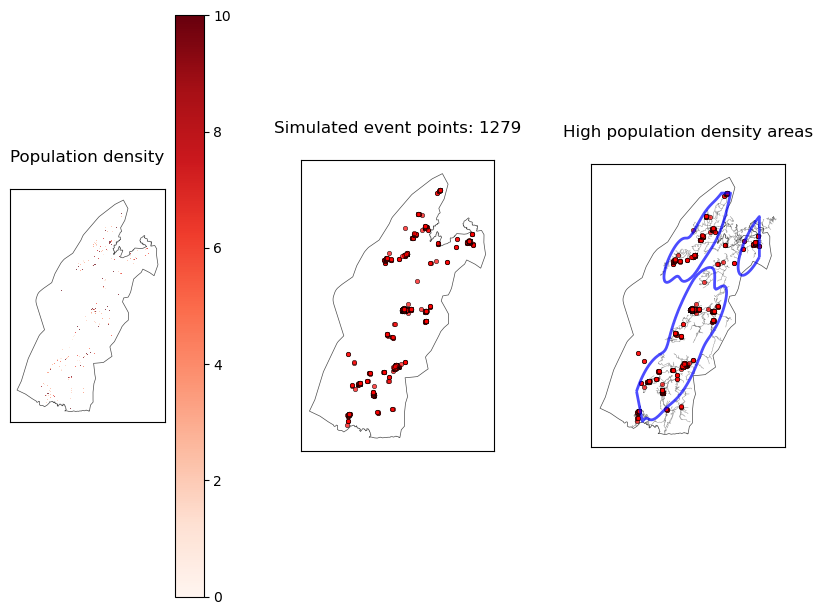

In [15]:
# Plot the population density, simulated event points, and high population density areas side-by-side
utilityModule.plot_population_density_and_event_points(Nordland_polygon_gdf, population_gdf, 
                                                        event_points_gdf, high_pop_density_area, edges, set_vmax=10)

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measures as node attributes  
2.2 Sample candidate points and filter out best candidate points

### 2.1 Add Centrality measure as node attribute

Closeness centrality is a measure of how close a node is to all other nodes in the network.  
Betweenness centrality is a measure of how many shortest paths pass through a node.

In [16]:
# if centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)
if 'betweenness_centrality' in nodes.columns:
    nodes.drop(columns=['betweenness_centrality'], inplace=True)

# import node closeness centrality from file
nodes_centrality_import = pd.read_csv("../data/Nordland/NordlandNodeCentrality.csv")

# Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

y          x  street_count    lon    lat highway  \
osmid                                                                   
201344755  7258568.424 426116.773             3 13.407 65.441     NaN   
8977449204 7261277.120 426285.657             3 13.409 65.466     NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
201344755   POINT (426116.773 7258568.424)                 0.000   
8977449204  POINT (426285.657 7261277.120)                 0.000   

            betweenness_centrality  
osmid                               
201344755                23593.000  
8977449204               37448.000

### 2.2 Sample candidate points and filter out best candidate points

In [17]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 100

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 17673, nr of police car nodes: 100


y          x  street_count    lon    lat highway  \
osmid                                                                   
1395393172 7463931.540 481114.648             1 14.562 67.291     NaN   
7320328844 7354218.941 461192.741             3 14.135 66.305     NaN   

                                  geometry  closeness_centrality  \
osmid                                                              
1395393172  POINT (481114.648 7463931.540)                 0.000   
7320328844  POINT (461192.741 7354218.941)                 0.000   

            betweenness_centrality  
osmid                               
1395393172                   0.000  
7320328844            34313179.000

Input nr of car nodes: 100
Remaining nr of car nodes: 75, after discarding the 25 (25%) remote car nodes with lowest closeness centrality
Centrality Measure: closeness


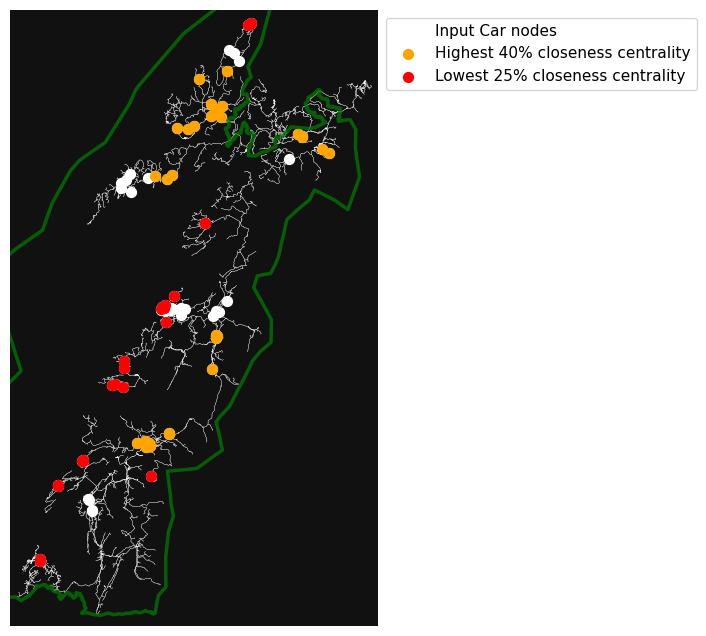

In [18]:
# Filter Car nodes by closeness centrality
car_nodes_gdf_central1 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf, district_boundary=Nordland_polygon_gdf, 
                            top_percent=0.4, bottom_percent=0.25, input_graph=Nordland_graph, centrality_measure="closeness", plot=True)

Input nr of car nodes: 75
Remaining nr of car nodes: 53, after discarding the 22 (30%) remote car nodes with lowest betweenness centrality
Centrality Measure: betweenness


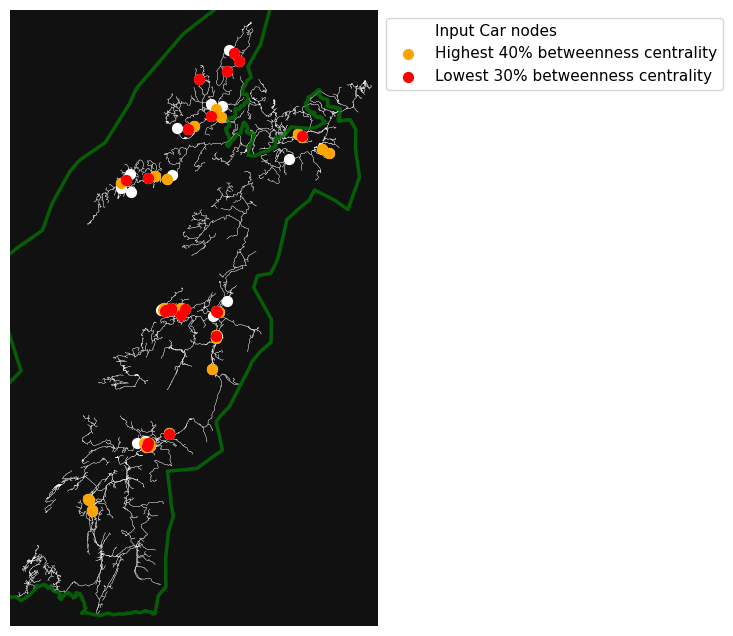

In [19]:
# Filter Car nodes by betweenness centrality
car_nodes_gdf_central2 = utilityModule.filter_by_centrality(geo_df=car_nodes_gdf_central1, district_boundary=Nordland_polygon_gdf, 
                        top_percent=0.4, bottom_percent=0.30, input_graph=Nordland_graph, centrality_measure="betweenness", plot=True)

Input nr of car nodes: 53
Remaining nr of car nodes: 29, after removing the 24 nodes that are within 5000 m of each other



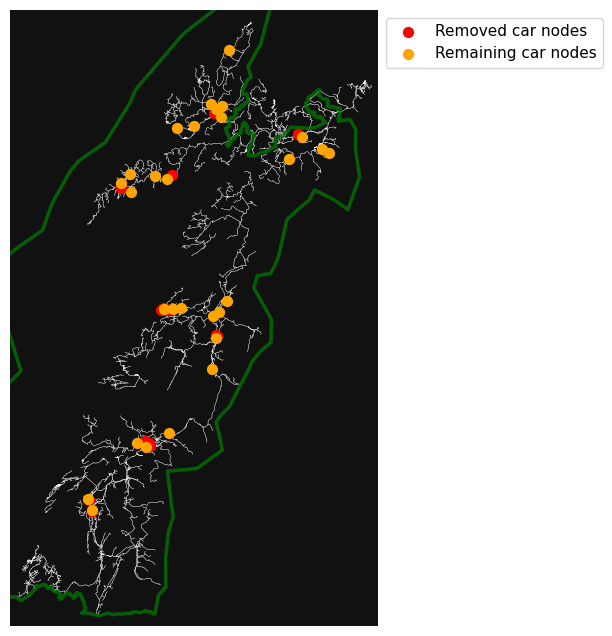

In [20]:
# Filter Car nodes by proximity to each other
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central2, district_boundary=Nordland_polygon_gdf, 
                        min_distance=5000, input_graph=Nordland_graph, criterion_col='betweenness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

We use the GeoDataFrames from `osmnx` to create a `pandana` network with both ``length`` and ``travel_time`` as edge weights.  
We have to specify which one to use when querying the network (cannot calculate with both at the same time).

In [21]:
# reset index so our origins and destinations are not in index
edges = edges_increased.reset_index() # increased edge speed
# edges = edges.reset_index()         # original edge speed

Number of connected components: 2
Number of nodes in component 0: 11804
Number of nodes in component 1: 5869
Total number of nodes in all components: 17673


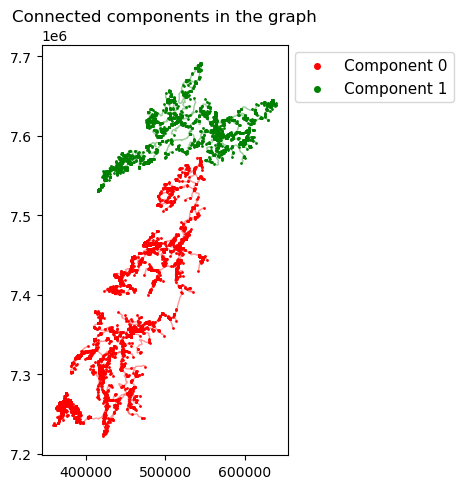

In [22]:
# find connected components
connected_components = utilityModule.find_connected_components(Nordland_graph, verbose=True, plot=True)

In [23]:
# convert northern and southern graphs to GeoDataFrames
nodes_north, edges_north = ox.graph_to_gdfs(connected_components[1], nodes=True, edges=True)
nodes_south, edges_south = ox.graph_to_gdfs(connected_components[0], nodes=True, edges=True)

# reset index of edges
edges_north = edges_north.reset_index()
edges_south = edges_south.reset_index()
edges_north.head(1)

u           v  key      osmid         name      highway  oneway  \
0  5351505926  1654396597    0  152635464  Skolebakken  residential   False   

  reversed  length                                           geometry  ...  \
0    False 174.845  LINESTRING (525621.399 7651089.411, 525618.500...  ...   

   travel_time  bridge maxspeed  ref lanes width tunnel junction access  \
0       18.400     NaN      NaN  NaN   NaN   NaN    NaN      NaN    NaN   

  service  
0     NaN  

[1 rows x 21 columns]

In [24]:
# create network with pandana
Nordland_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# create pandana network for northern and southern graphs
Nordland_network_pdna_north = pdna.Network(node_x=nodes_north['x'], node_y=nodes_north['y'], 
                                     edge_from=edges_north['u'], edge_to=edges_north['v'], 
                                     edge_weights=edges_north[["length", "travel_time"]], twoway=True)

Nordland_network_pdna_south = pdna.Network(node_x=nodes_south['x'], node_y=nodes_south['y'],
                                        edge_from=edges_south['u'], edge_to=edges_south['v'], 
                                        edge_weights=edges_south[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of Nordland_network_pdna: {type(Nordland_network_pdna)}")
print(f"Network nodes:")
Nordland_network_pdna.nodes_df.head(1)

type of Nordland_network_pdna: <class 'pandana.network.Network'>
Network nodes:


x           y
osmid                           
201344755 426116.773 7258568.424

In [25]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = Nordland_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

geometry   nearest_node          x           y
0  POINT (368054.442 7245988.412) 7300174884.000 368007.237 7245994.728
1  POINT (369161.658 7252205.190) 7300174189.000 369158.984 7252187.716

Length of original event_points_gdf: 1269
Length of northern event_points_gdf: 388
Length of southern event_points_gdf: 881


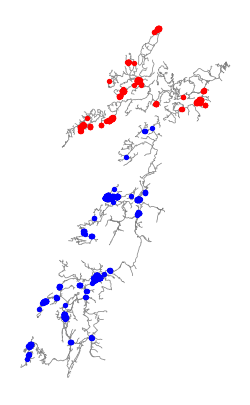

In [26]:
# split event_points_gdf into northern part and southern part by checking if the nearest node is in northern or southern graph
event_points_gdf_north = event_points_gdf[event_points_gdf['nearest_node'].isin(nodes_north.index)]
event_points_gdf_south = event_points_gdf[event_points_gdf['nearest_node'].isin(nodes_south.index)]

# verify the lengths of the split dataframes compared to the original
print(f"Length of original event_points_gdf: {len(event_points_gdf)}")
print(f"Length of northern event_points_gdf: {len(event_points_gdf_north)}")
print(f"Length of southern event_points_gdf: {len(event_points_gdf_south)}")

# plot the event points in the northern and southern parts in different colors
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
edges_north.plot(ax=ax, linewidth=0.5, color='gray', zorder=-1)
edges_south.plot(ax=ax, linewidth=0.5, color='gray', zorder=-1)
event_points_gdf_north.plot(ax=ax, color='red', markersize=8)
event_points_gdf_south.plot(ax=ax, color='blue', markersize=8)
# plt.title("Event points in northern and southern parts")
plt.axis("off"); plt.show()

In [27]:
# reset index so we have 1 header row and not 2
nodes_north.reset_index(drop=False, inplace=True)
nodes_south.reset_index(drop=False, inplace=True)
nodes_north.head(2)

osmid           y          x  street_count    lon    lat highway  \
0  5351505926 7651089.411 525621.399             3 15.640 68.969     NaN   
1  1654396597 7651005.144 525513.327             1 15.637 68.969     NaN   

                         geometry  
0  POINT (525621.399 7651089.411)  
1  POINT (525513.327 7651005.144)

Length of original car_nodes_gdf: 29
Length of north car_nodes_gdf: 16
Length of southern car_nodes_gdf: 13


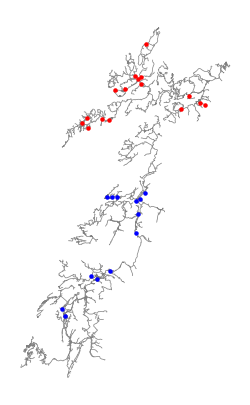

In [28]:
# split car_nodes_gdf into north part and southern part by checking if the nearest node is in north or southern graph
car_nodes_gdf_north = car_nodes_gdf_filtered[car_nodes_gdf_filtered['osmid'].isin(nodes_north['osmid'])]
car_nodes_gdf_south = car_nodes_gdf_filtered[car_nodes_gdf_filtered['osmid'].isin(nodes_south['osmid'])]

# verify the lengths of the split dataframes compared to the original
print(f"Length of original car_nodes_gdf: {len(car_nodes_gdf_filtered)}")
print(f"Length of north car_nodes_gdf: {len(car_nodes_gdf_north)}")
print(f"Length of southern car_nodes_gdf: {len(car_nodes_gdf_south)}")

# plot the car nodes in the north and southern parts in different colors
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
edges_north.plot(ax=ax, linewidth=0.5, color='gray', zorder=-1)
edges_south.plot(ax=ax, linewidth=0.5, color='gray', zorder=-1)
car_nodes_gdf_north.plot(ax=ax, color='red', markersize=5)
car_nodes_gdf_south.plot(ax=ax, color='blue', markersize=5)
# plt.title("Car nodes in north and southern parts")
plt.axis("off"); plt.show()

In [29]:
# Get list of nearest node ids for event locations
event_nodes_pdna = Nordland_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = Nordland_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([ 5837710183,  7320328844,  5837708276,    33578737, 11672122609],
      dtype=int64)

In [30]:
# Get list of nearest node ids for event locations
event_nodes_pdna_north = Nordland_network_pdna_north.get_node_ids(x_col=event_points_gdf_north.geometry.x, y_col=event_points_gdf_north.geometry.y).values
event_nodes_pdna_south = Nordland_network_pdna_south.get_node_ids(x_col=event_points_gdf_south.geometry.x, y_col=event_points_gdf_south.geometry.y).values

# get the nearest node ids (in this case, just selecting the 'osnorth')
car_nodes_pdna_north = Nordland_network_pdna_north.get_node_ids(x_col=car_nodes_gdf_north.x, y_col=car_nodes_gdf_north.y).values
car_nodes_pdna_south = Nordland_network_pdna_south.get_node_ids(x_col=car_nodes_gdf_south.x, y_col=car_nodes_gdf_south.y).values
car_nodes_pdna[:5]

array([ 5837710183,  7320328844,  5837708276,    33578737, 11672122609],
      dtype=int64)

In [31]:
# # Plot overview of Car nodes and Event nodes
# fig, ax = ox.plot_graph(Nordland_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
# ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
# ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
# plt.show()

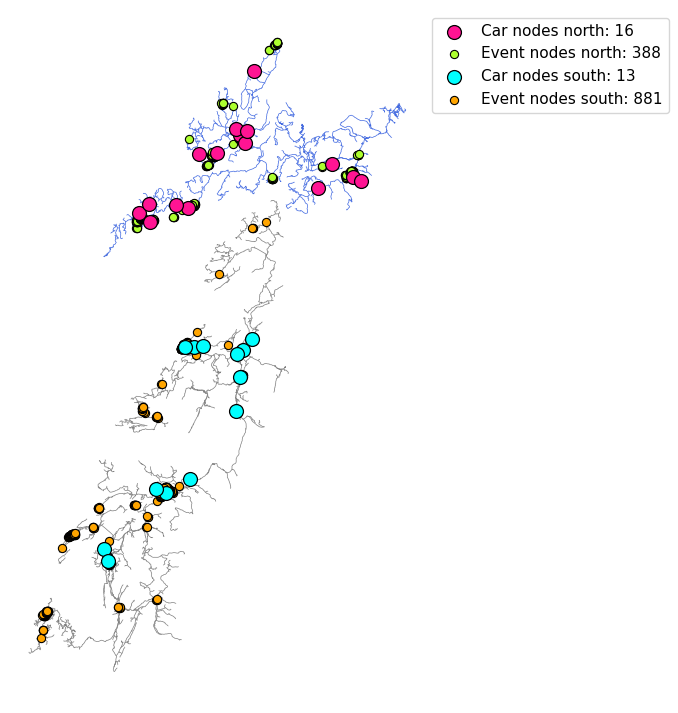

In [32]:
# Plot overview of Car nodes and Event nodes - in the north and southern network parts
fig, ax = plt.subplots(figsize=(9, 9))
edges_north.plot(ax=ax, linewidth=0.5, color='royalblue', zorder=-1)
edges_south.plot(ax=ax, linewidth=0.5, color='gray', zorder=-1)
ax.scatter(car_nodes_gdf_north['x'], car_nodes_gdf_north['y'], c='deeppink', edgecolor='black', lw=0.90, s=100, label=f"Car nodes north: {len(car_nodes_gdf_north)}", zorder=3)
ax.scatter(event_points_gdf_north['x'], event_points_gdf_north['y'], c='greenyellow', s=35, edgecolor='black', lw=0.80, label=f"Event nodes north: {len(event_points_gdf_north)}", zorder=2)
ax.scatter(car_nodes_gdf_south['x'], car_nodes_gdf_south['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes south: {len(car_nodes_gdf_south)}", zorder=3)
ax.scatter(event_points_gdf_south['x'], event_points_gdf_south['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes south: {len(event_points_gdf_south)}", zorder=2)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=11)
plt.axis("off"); plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

Building Cost Matrix:
- Cross-join all events and car locations to get all possible origin-destination pairs.
- Compute the travel time of each combination using Pandana `shortest_path_lengths()`

In [33]:
# Creating origins-destination pairs
origins_north = np.repeat(car_nodes_pdna_north, len(event_nodes_pdna_north))
origins_south = np.repeat(car_nodes_pdna_south, len(event_nodes_pdna_south))
destinations_north = np.tile(event_nodes_pdna_north, len(car_nodes_pdna_north))
destinations_south = np.tile(event_nodes_pdna_south, len(car_nodes_pdna_south))

In [34]:
%%time
# travel time between each possible pair of car-event combination - in north and southern parts
distances_north = Nordland_network_pdna_north.shortest_path_lengths(origins_north, destinations_north, imp_name='length')
distances_south = Nordland_network_pdna_south.shortest_path_lengths(origins_south, destinations_south, imp_name='length')
travel_times_north = Nordland_network_pdna_north.shortest_path_lengths(origins_north, destinations_north, imp_name='travel_time')
travel_times_south = Nordland_network_pdna_south.shortest_path_lengths(origins_south, destinations_south, imp_name='travel_time')
print(f"{len(car_nodes_pdna_north)+len(car_nodes_pdna_south)} origins x {len(event_nodes_pdna_north)+len(event_nodes_pdna_south)} destinations = {len(origins_north)+len(origins_south)} origin-destination pairs (problem size)")
print("(Not a direct cross-join here, since working with multiple disconnected graphs)\n")
print("5 first origin-destination distances (north) [m]     :", distances_north[:5])
print("5 first origin-destination travel times (north) [sec]:", travel_times_north[:5])

29 origins x 1269 destinations = 17661 origin-destination pairs (problem size)
(Not a direct cross-join here, since working with multiple disconnected graphs)

5 first origin-destination distances (north) [m]     : [72172.813, 72238.105, 71932.478, 66761.847, 67274.497]
5 first origin-destination travel times (north) [sec]: [3813.7, 3836.5, 3810.9, 3451.9, 3516.2]
CPU times: total: 438 ms
Wall time: 130 ms


In [35]:
# describe statistics for travel times - horizontally
travel_times_df = pd.DataFrame(travel_times_north) / 60 # in minutes
travel_times_df.describe().T

count    mean    std   min    25%     50%     75%     max
0 6208.000 127.049 76.083 0.023 47.246 145.616 185.161 285.825

In [36]:
# Restructure the distances and travel times arrays into a DataFrame (CSouthWest Matrix) and add the car and event node ids as columns
# create a DataFrame from the distances and travel times arrays
CostMatrix_north = pd.DataFrame({'distance': distances_north, 'travel_time': travel_times_north})
CostMatrix_south = pd.DataFrame({'distance': distances_south, 'travel_time': travel_times_south})

# add the car and event node ids as columns
CostMatrix_north['carNodeID'] = np.repeat(car_nodes_pdna_north, len(event_nodes_pdna_north))
CostMatrix_north['eventNodeID'] = np.tile(event_nodes_pdna_north, len(car_nodes_pdna_north))
CostMatrix_south['carNodeID'] = np.repeat(car_nodes_pdna_south, len(event_nodes_pdna_south))
CostMatrix_south['eventNodeID'] = np.tile(event_nodes_pdna_south, len(car_nodes_pdna_south))
# CostMatrix.head() # distances, travel times, car and event node ids

# add the north and south to a total CostMatrix
CostMatrix = pd.concat([CostMatrix_north, CostMatrix_south], axis=0)
CostMatrix.head(2)

distance  travel_time  carNodeID  eventNodeID
0 72172.813     3813.700   33578737   5433593254
1 72238.105     3836.500   33578737   1839031274

In [37]:
# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

distance  travel_time  carNodeID  eventNodeID          x           y
0 72172.813     3813.700   33578737   5433593254 439169.401 7551851.759
1 72238.105     3836.500   33578737   1839031274 439467.986 7551801.968

In [38]:
# Save cNordland matrix to CSV
CostMatrix.to_csv("../data/Nordland/NordlandCostMatrix.csv", index=False)

# drop the distance column from the CostMatrix, just using travel time
CostMatrix.drop(columns="distance", inplace=True)

We have 2 Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

#### Notation
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events locations, a subset of $N$.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.
- $K$ : The number of police cars available.
- $M$ : The maximum number of events that can be assigned to a police car.

#### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data for efficient computation
0) Add suffixes to eventNodeID's to preserve events that share same network nodes
1) Convert the cost matrix to a dictionary for faster iteration speed.
2) Reduce CostMatrix by filtering out the top X% travel times, as there probably is another closer car to the event. (optional)

In [39]:
# add suffix to duplicate eventNodeIDs
CostMatrix_suffix = utilityModule.suffix_duplicate_nodes(CostMatrix)
CostMatrix_suffix.head(2)

travel_time  carNodeID   eventNodeID
0     3813.700   33578737  5433593254_1
1     3836.500   33578737  1839031274_1

In [112]:
### Problem Setup parameters
# Problem reduction
DISCARD_THRESHOLD = 0.00

# Constants
NR_OF_CARS = 4
# margin = len(event_nodes_pdna) * 0.06 # 6% of all events
# CAR_CAPACITY = (len(event_nodes_pdna) // NR_OF_CARS) + round(margin)
CAR_CAPACITY = 495
print(f"Car capacity: {CAR_CAPACITY} events per car")

# # Sets
P = CostMatrix_suffix['carNodeID'].unique()  # All car locations
E = CostMatrix_suffix['eventNodeID'].unique()  # Events
nr_of_unique_events = len(E)
# Preprocess the cost matrix: convert to dict and reduce problem size
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix_suffix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Car capacity: 495 events per car
Filtering out 0% highest travel times - keeping only travel times <= 22537 sec, or 375.6 min
Original nr of pairs: 17661 | Filtered nr of pairs: 17661
Original max travel time: 22537.499 | Filtered max travel time: 22537.499


### 5.2 Setup LP problem

In [113]:
%%time
# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix_suffix, CostMatrix_dict_reduced, 
    nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 29
Number of events: 1269
Number of decision variables: 17690
Number of constraints: 18960
Number of non-zero coefficients: 17690
Number of non-zero coefficients in the objective function: 17661
CPU times: total: 688 ms
Wall time: 1.08 s


### 5.5 Run solver - PULP_CBC (COIN-OR Branch and Cut)

The solver is first run with relaxed integer variable constraint (`mip=False`) for fast computation.  
If the solver does not find all integer solutions, it is run again use proper integer constraints (`mip=True`).

In [114]:
%%time
# Run the solver
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100:.0f}%)")
solve = utilityModule.run_solvers(problem, P, nr_of_locations=NR_OF_CARS, 
                                solver_name='PULP_CBC_CMD', forceMIP=False, plot=False)

(Note: Currently reducing the Cost matrix by 0%)
Optimal police car locations found: 4/4 in 2.38 seconds: [1113240059 5403979563 7320328844  266556943]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 2928994.1780 seconds, or 48816.57 minutes, or 813.61 hours
CPU times: total: 1.16 s
Wall time: 3.39 s


### 5.6 Extract results for inspection

In [115]:
# Extract optimal police car locations
optimal_locations = {i: problem.variablesDict()[f"x_{i}"].varValue for i in P if problem.variablesDict()[f"x_{i}"].varValue == 1}
print("Optimal police car locations:", optimal_locations.keys())

# convert to geodataframe for plotting. Should contain the carNodeID and the geometry (Point)
optimal_locations_gdf = gpd.GeoDataFrame(geometry=[Point(nodes.loc[node, 'x'], nodes.loc[node, 'y']) for node in optimal_locations.keys()], crs="EPSG:32633")
optimal_locations_gdf['carNodeID'] = optimal_locations.keys()
carNodeID_list = list(optimal_locations_gdf['carNodeID'])

car_to_events_df = utilityModule.create_car_to_events_df(CostMatrix_extended, optimal_locations, problem, 
                                                         CAR_CAPACITY, nr_of_unique_events, verbose=True)
car_to_events_df.to_csv("../data/Nordland/NordlandCarToEventsAssignment.csv", index=False) # export the car to events assignment to CSV

Optimal police car locations: dict_keys([1113240059, 5403979563, 7320328844, 266556943])
Car 1113240059 is assigned 134/495 events
Car 5403979563 is assigned 254/495 events
Car 7320328844 is assigned 386/495 events
Car 266556943 is assigned 495/495 events
Summing the events for each car gives 1269 events, which should equal the total number of unique events: 1269


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 29 | Optimal locations in solution: 4
- Events: 1269 | Max event capacity per police car: 495

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 2928994 sec | 48816.6 min | 813.61 hours

Car id: 1113240059 handles 134 events | Capacity: 27.07% | Total response time: 1148.11 min | Median: 7.01 min | Avg: 8.57 min
Car id: 5403979563 handles 254 events | Capacity: 51.31% | Total response time: 17697.01 min | Median: 86.49 min | Avg: 69.67 min
Car id: 7320328844 handles 386 events | Capacity: 77.98% | Total response time: 21163.34 min | Median: 59.62 min | Avg: 54.83 min
Car id: 266556943 handles 495 events | Capacity: 100.00% | Total response time: 8808.11 min | Median: 5.13 min | Avg: 17.79 min


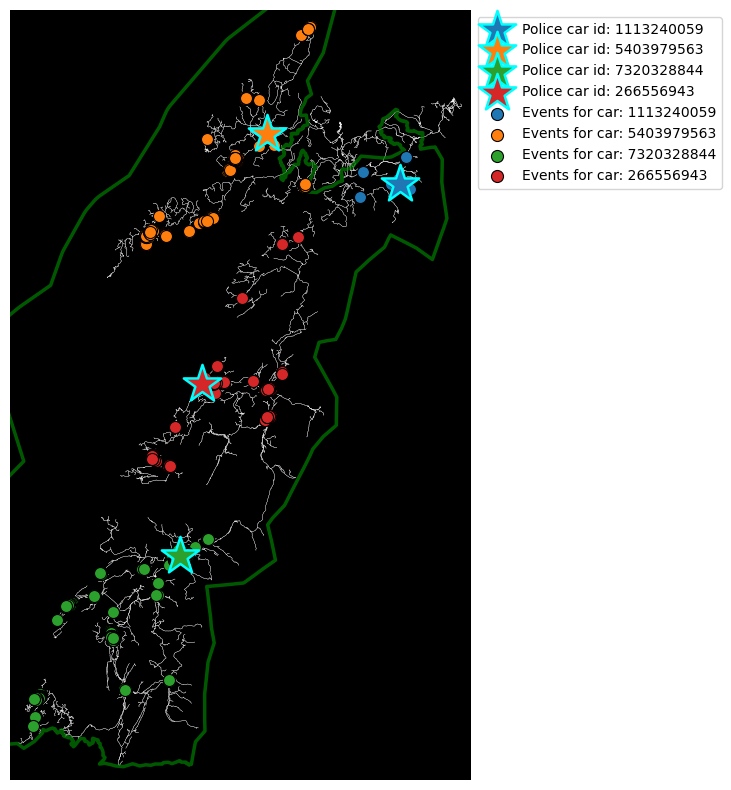

CPU times: total: 2.61 s
Wall time: 3.05 s


In [116]:
%%time
# Plot the optimal car locations and the assigned events
utilityModule.plot_optimal_allocations(Nordland_graph, Nordland_polygon_gdf, optimal_locations_gdf, car_to_events_df, 
                        car_nodes_gdf_filtered, nr_of_unique_events, NR_OF_CARS, CAR_CAPACITY, problem, figsize=(10,10))

## 6.2 Visualize Isochrones - How far can you drive in different time intervals?
How far can you drive in 1.5, 4 and 8 minutes from the origin nodes? We'll use NetworkX to induce a subgraph of gruner_graph within each distance, based on travel time.  
We also, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [121]:
# Define how many trip times to visualize
TRIP_TIMES = [20, 60, 120]  # in minutes
ISO_COLORS = ['royalblue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [122]:
%%time
# Generate isochrone polygons
isochrone_polys = utilityModule.make_iso_polys(Nordland_graph_increased, TRIP_TIMES, carNodeID_list, 
                                                edge_buff=700, node_buff=0, infill=True)
# Merge isochrones
merged_isochrones = utilityModule.merge_isochrones(isochrone_polys)

CPU times: total: 22.4 s
Wall time: 25.9 s


Isochrone polygons for the travel times: [20, 60, 120] minutes


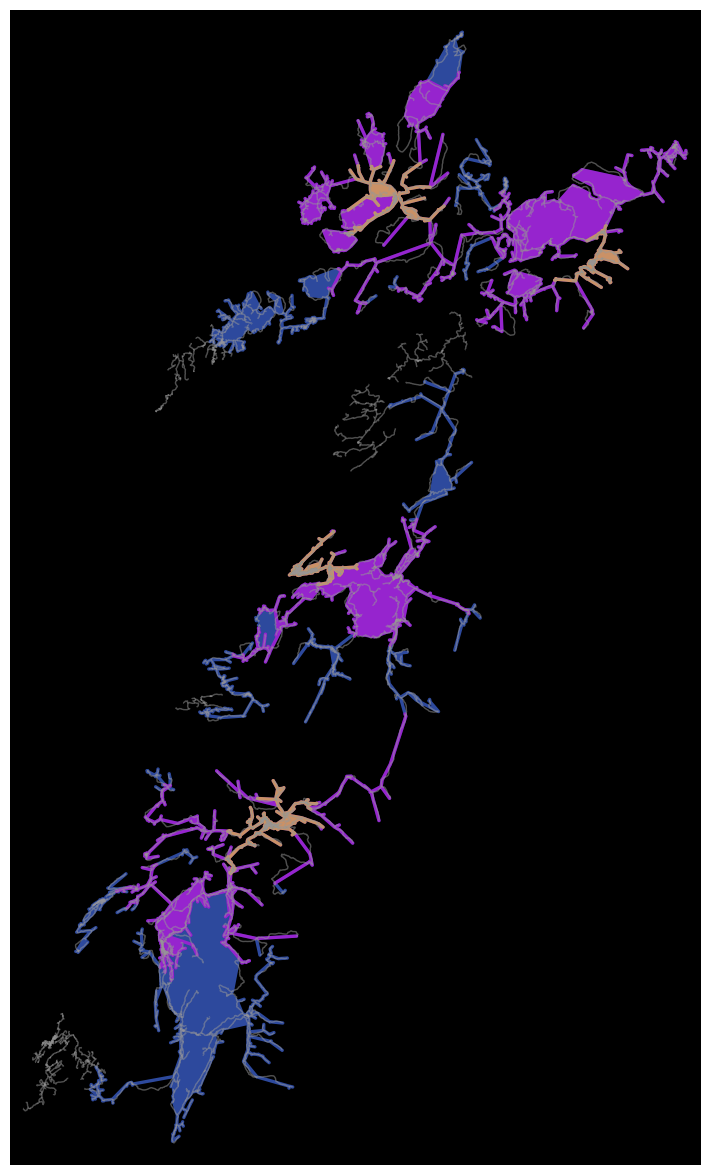

In [123]:
# Plotting the graph and merged isochrones
fig, ax = ox.plot_graph(Nordland_graph_increased, show=False, close=False, edge_color='#999999', 
                        edge_alpha=0.3, node_size=0, bgcolor='k', figsize=(15, 15))

# Plotting merged isochrones with colors
for i, (merged_poly, color) in enumerate(zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS)):
    alpha_value = 0.7 if i == 0 else 0.5  # less transparent long-range(i=0)
    if isinstance(merged_poly, MultiPolygon):
        for poly in merged_poly.geoms:
            patch = PolygonPatch(poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
            ax.add_patch(patch)
    else:
        patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=alpha_value, zorder=-1)
        ax.add_patch(patch)
print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
plt.show()

### 6.3 Visualize isochrones on interactive map

In [124]:
%%time
# Plot leaflet map
isochrone_map = utilityModule.plot_leaflet_map(Nordland_graph, TRIP_TIMES, merged_isochrones, Nordland_polygon_gdf, background_poly=True)
isochrone_map

CPU times: total: 781 ms
Wall time: 986 ms
